# **4-Text Classification**


#### **Anggota Kelompok**
- Elmosius Suli (2272008)
- Christopher Wijaya (2272016)
- Josephine Alvina Luwia (2272029)
- Samuel Setyawan Prakasa (2272030)



<br/>

**Sumber:** https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html

---

<br/>



 <br/>



>  **Spam Filter in Python: Naive Bayes from Scratch**

##### **1. Exploring the Dataset**

Langkah pertama dalam membangun model Naive Bayes untuk klasifikasi teks adalah memahami dataset.Dalam studi kasus ini, dataset yang digunakan adalah SMSSpamCollection, yaitu kumpulan pesan SMS yang dikategorikan sebagai spam atau ham (bukan spam).

Dataset ini berisi dua kolom utama:

* Label — menunjukkan apakah pesan tersebut “spam” atau “ham”.
* SMS — berisi isi teks dari pesan.

Kita akan membaca dataset tersebut menggunakan pustaka pandas, yang sering digunakan untuk mengelola data tabular di Python.Agar data bisa terbaca dengan benar:
* Kita gunakan sep='\t' karena file ini dipisahkan oleh tab.
* Kita gunakan header=None karena file tidak punya nama kolom.
* Kita tambahkan names=['Label', 'SMS'] agar kolom memiliki nama yang jelas

In [1]:
import pandas as pd

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t',
header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##### **2. Menghitung Probabilitas Prior (Prior Probability)**

Pada tahap ini, kita ingin mengetahui proporsi antara pesan spam dan pesan non-spam (ham) di dalam dataset. Dengan kata lain, kita menghitung probabilitas awal (prior) dari masing-masing kategori sebelum melihat isi teksnya.


In [5]:
prob_prior = sms_spam['Label'].value_counts(normalize=True)
print(prob_prior)


Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


##### **3. Membagi Dataset Menjadi Data Latih dan Data Uji (Training and Test Set)**

Agar model dapat belajar dan dievaluasi dengan adil, dataset biasanya dibagi menjadi dua bagian:

* Data Latih (Training Set) digunakan untuk melatih model agar mengenali pola dari data.
* Data Uji (Test Set) digunakan untuk menguji performa model pada data baru yang belum pernah dilihat sebelumnya.

In [6]:
# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


##### **4. Analisis Distribusi Label pada Data Latih (Training Set)**

Setelah kita membagi dataset menjadi data latih (training set) dan data uji (test set), penting untuk memeriksa apakah proporsi label spam dan ham tetap seimbang seperti di dataset awal.

In [9]:
training_set['Label'].value_counts(normalize=True)

,proportion
Label,
ham,0.86541
spam,0.13459


In [10]:
test_set['Label'].value_counts(normalize=True)

,proportion
Label,
ham,0.868043
spam,0.131957


##### **5. Data Cleaning**

Sebelum melatih model Naive Bayes, kita perlu melakukan pra-pemrosesan teks (text preprocessing) agar data siap digunakan.

Teks dalam bentuk mentah sering mengandung:

* Huruf kapital (misalnya “FREE” dan “free” dianggap berbeda padahal sama maknanya),
* Tanda baca (seperti koma, titik, tanda seru, dsb.),
* Simbol non-alfabet yang tidak berkontribusi terhadap makna.


In [11]:
# Before cleaning
training_set.head(3)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired


Karena model bag-of-words yang digunakan oleh Naive Bayes tidak peduli pada huruf besar maupun tanda baca, maka kita akan:

* Menghapus tanda baca dan simbol.
* Mengubah semua huruf menjadi huruf kecil (lowercase) agar konsisten.

In [12]:
# Menghapus tanda baca dan simbol non-huruf
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True)

# Mengubah seluruh teks menjadi huruf kecil
training_set['SMS'] = training_set['SMS'].str.lower()

# Melihat hasil setelah dibersihkan
training_set.head(3)


<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-3710906242.py:2: SyntaxWarning: invalid escape sequence '\W'
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True)


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired


##### **6. Membuat Vocabulary (Daftar Kata Unik)**

Setelah teks dibersihkan, langkah selanjutnya adalah membuat vocabulary, yaitu kumpulan semua kata unik yang muncul di seluruh pesan SMS pada data latih.

Konsepnya:
* Tiap kata yang pernah muncul akan menjadi fitur (feature).
* Model Naive Bayes nantinya akan menghitung berapa kali tiap kata muncul dalam pesan spam dan ham.

In [13]:
# Mengubah setiap pesan menjadi list kata
training_set['SMS'] = training_set['SMS'].str.split()

# Membuat daftar kosong untuk menampung semua kata
vocabulary = []

# Mengisi vocabulary dengan semua kata dari setiap pesan
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

# Menghapus duplikat kata dengan set() lalu ubah kembali ke list
vocabulary = list(set(vocabulary))

# Menampilkan jumlah kata unik dalam vocabulary
print("Jumlah kata unik dalam data latih:", len(vocabulary))


Jumlah kata unik dalam data latih: 7783


##### **7. Membentuk Final Training Set (Representasi Bag-of-Words)**



In [15]:
# Membuat dictionary awal, tiap kata punya daftar nol sepanjang jumlah SMS
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

# Mengisi jumlah kemunculan tiap kata dalam setiap pesan
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

# Mengubah dictionary menjadi DataFrame
word_counts = pd.DataFrame(word_counts_per_sms)

# Menampilkan beberapa baris pertama dari DataFrame hasil transformasi
word_counts.head()


,yoville,lyrics,comment,lipo,speeding,neva,howz,urgran,stones,vu,...,studying,smokin,chit,bike,atlast,nike,thinks,mids,resend,employee
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sekarang kita gabungkan DataFrame word_counts dengan DataFrame training_set agar punya kolom lengkap (Label, SMS, dan seluruh fitur kata).

In [16]:
# Menggabungkan data Label + SMS dengan DataFrame word counts
training_set_clean = pd.concat([training_set, word_counts], axis=1)

# Melihat hasil akhir dari training set
training_set_clean.head()

,Label,SMS,yoville,lyrics,comment,lipo,speeding,neva,howz,urgran,...,studying,smokin,chit,bike,atlast,nike,thinks,mids,resend,employee
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### **8. Menghitung Konstanta Awal (Calculating Constants First)**

Sekarang dataset sudah siap (sudah dibersihkan dan dikonversi ke bentuk bag-of-words). Langkah berikutnya adalah menghitung beberapa konstanta penting yang akan digunakan dalam perhitungan Naive Bayes.


Model Multinomial Naive Bayes menggunakan dua rumus utama:

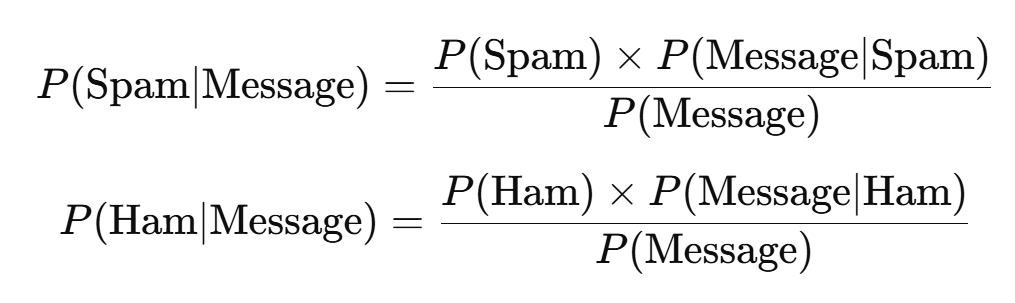


Untuk menghitung P(Message | Spam) dan P(Message | Ham), kita perlu menghitung P(wᵢ | Spam) dan P(wᵢ | Ham) (probabilitas suatu kata wᵢ muncul dalam pesan spam atau ham).

Rumusnya:

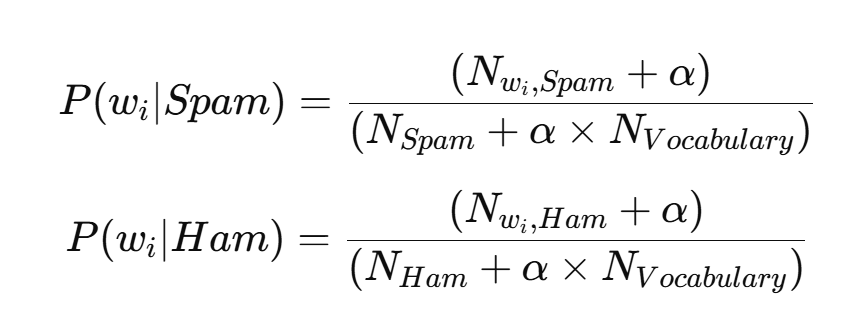

In [17]:
# Memisahkan pesan spam dan ham
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# Menghitung probabilitas prior
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# Menghitung total jumlah kata dalam semua pesan spam (N_Spam)
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# Menghitung total jumlah kata dalam semua pesan ham (N_Ham)
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# Menghitung jumlah total kata unik di vocabulary (N_Vocabulary)
n_vocabulary = len(vocabulary)

# Menetapkan nilai alpha untuk Laplace smoothing
alpha = 1

# Menampilkan hasil
print("P(Spam):", p_spam)
print("P(Ham):", p_ham)
print("Total kata dalam spam (N_Spam):", n_spam)
print("Total kata dalam ham (N_Ham):", n_ham)
print("Jumlah kata unik (N_Vocabulary):", n_vocabulary)
print("Alpha (Laplace smoothing):", alpha)


P(Spam): 0.13458950201884254
P(Ham): 0.8654104979811574
Total kata dalam spam (N_Spam): 15190
Total kata dalam ham (N_Ham): 57237
Jumlah kata unik (N_Vocabulary): 7783
Alpha (Laplace smoothing): 1


##### **9. Menghitung Parameter P(wi | Spam) & P(wi | Ham)**

In [18]:
# Inisialisasi dict parameter untuk setiap kata di vocabulary
parameters_spam = {unique_word: 0.0 for unique_word in vocabulary}
parameters_ham  = {unique_word: 0.0 for unique_word in vocabulary}

# Hitung likelihood per kata dengan Laplace smoothing
for word in vocabulary:
    # Jumlah kemunculan kata 'word' pada seluruh pesan spam/ham
    # (kolom 'word' berasal dari word_counts yang digabung ke training_set_clean)
    n_word_given_spam = spam_messages[word].sum()
    n_word_given_ham  = ham_messages[word].sum()

    # P(word | Spam)
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam

    # P(word | Ham)
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)
    parameters_ham[word] = p_word_given_ham

# Cek beberapa contoh nilai
sample_words = ['free','win','claim','cousin','lovely']
{w: (parameters_spam.get(w, None), parameters_ham.get(w, None)) for w in sample_words}


{'free': (np.float64(0.00766116745745005), np.float64(0.0007536142725315288)),
 'win': (np.float64(0.00226352674879206), np.float64(0.00019993848046754843)),
 'claim': (np.float64(0.003961171810386106),
  np.float64(1.537988311288834e-05)),
 'cousin': (np.float64(4.3529360553693465e-05),
  np.float64(3.075976622577668e-05)),
 'lovely': (np.float64(4.3529360553693465e-05),
  np.float64(0.00019993848046754843))}

##### **10. Klasifikasi Pesan Baru (Classifying a New Message)**

Setelah seluruh parameter seperti P(Spam), P(Ham), serta P(wᵢ|Spam) dan P(wᵢ|Ham) berhasil dihitung, langkah selanjutnya adalah membangun fungsi klasifikasi pesan baru.

Fungsi ini bertugas untuk menentukan apakah sebuah pesan baru termasuk kategori spam atau ham (non-spam).

Secara konseptual, fungsi ini akan menghitung dua probabilitas utama:
1. P(Spam | w1, w2, ..., wn)
2. P(Ham | w1, w2, ..., wn)

Kemudian, kedua nilai tersebut dibandingkan:
* Jika P(Ham | message) > P(Spam | message), maka pesan diklasifikasikan sebagai ham
* Jika P(Ham | message) < P(Spam | message), maka pesan diklasisifkasikan sebagai spam
* Jika nilainya sama, maka algoritma akan membutuhkan verifikasi manusia

In [19]:
import re

def classify(message):
    '''
    Fungsi untuk mengklasifikasikan pesan baru
    message: string teks SMS
    '''

    # 1️⃣ Data Cleaning (hapus tanda baca, ubah ke huruf kecil, dan pisahkan kata)
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    # 2️⃣ Inisialisasi probabilitas awal dengan P(Spam) dan P(Ham)
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    # 3️⃣ Hitung probabilitas pesan berdasarkan setiap kata dalam pesan
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # 4️⃣ Tampilkan hasil perhitungan probabilitas
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    # 5️⃣ Tentukan label berdasarkan probabilitas tertinggi
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities — need human review!')


<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-1627569070.py:10: SyntaxWarning: invalid escape sequence '\W'
  message = re.sub('\W', ' ', message)


Sekarang kita coba dua pesan baru — satu spam, satu ham:

In [20]:
# Pesan spam (jelas mengandung kata pemenang, kode rahasia, uang, dll.)
classify('WINNER!! This is the secret code to unlock the money: C3421.')

# Pesan ham (pesan biasa tanpa indikasi promosi atau spam)
classify("Sounds good, Tom, then see u there")


P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam
P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


##### **11. Mengukur Akurasi Spam Filter (Measuring the Spam Filter’s Accuracy)**

Setelah model selesai dibuat dan fungsi klasifikasi sudah berjalan dengan baik, langkah selanjutnya adalah mengevaluasi performa model menggunakan data uji (test set).

Pada tahap ini, kita ingin mengetahui seberapa sering model membuat prediksi yang benar dibandingkan dengan label asli.
Untuk mengukurnya, kita akan menggunakan akurasi (accuracy), yaitu rasio antara jumlah prediksi benar terhadap total jumlah prediksi.

In [22]:
import re

# Fungsi klasifikasi untuk data uji
def classify_test_set(message):
    '''
    message: sebuah string (pesan SMS)
    '''
    # Tahap 1: Pembersihan teks
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    # Tahap 2: Inisialisasi probabilitas awal
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    # Tahap 3: Kalikan probabilitas tiap kata (jika ada dalam vocabulary)
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    # Tahap 4: Kembalikan label hasil klasifikasi
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'


<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-4244462605.py:9: SyntaxWarning: invalid escape sequence '\W'
  message = re.sub('\W', ' ', message)


Setelah fungsi ini dibuat, kita bisa menggunakannya untuk mengklasifikasikan seluruh pesan di test set.

In [23]:
# Menerapkan fungsi klasifikasi ke setiap pesan di test set
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)

# Menampilkan beberapa baris hasil prediksi
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Langkah berikutnya adalah membandingkan hasil prediksi (predicted) dengan label asli (Label) untuk menghitung jumlah prediksi benar dan salah.

In [24]:
correct = 0
total = test_set.shape[0]  # total pesan di test set

# Loop untuk menghitung jumlah prediksi benar
for row in test_set.iterrows():
    row = row[1]  # ambil isi barisnya
    if row['Label'] == row['predicted']:
        correct += 1

# Menampilkan hasil evaluasi
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct / total)


Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833
